In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May  9 03:54:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    42W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score,matthews_corrcoef
import random
import os
import io
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup
from tqdm import tqdm, trange,tnrange,tqdm_notebook
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('wordnet')
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/DLBBT01/data/a_raw_labeled/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DLBBT01/data/a_raw_labeled/test.csv')

# **Labeled Dataset for training model.**

https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp

In [ ]:
pd.set_option('display.max_colwidth', 160)
train_df.head()

,text,sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,love
4,i am feeling grouchy,anger


In [ ]:
train_df.isnull().sum()

text         0
sentiment    0
dtype: int64

In [ ]:
train_df['sentiment'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [ ]:
train_df['sentiment'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: sentiment, dtype: int64

In [ ]:
def clean_text(text):
    import re
    from string import punctuation
    text=re.sub(r'(http|ftp|https):\/\/([\w\-_]+(?:(?:\.[\w\-_]+)+))([\w\-\.,@?^=%&:/~\+#]*[\w\-\@?^=%&/~\+#])?', 
                ' ', text)
    text=re.sub(r'['+punctuation+']',' ',text)
    text=re.sub(r'#(\w+)',' ',text)
    text=re.sub(r'@(\w+)',' ',text)
    text = text.lower() # Convert  to lowercase
    token=RegexpTokenizer(r'\w+')
    tokens = token.tokenize(text)
    lemmatizer = WordNetLemmatizer()
    stems = [lemmatizer.lemmatize(t) for t in tokens]
    stemmer = PorterStemmer()
    stems = [stemmer.stem(t) for t in stems]    
    return ' '.join(stems)

# **Clean_dataset**

In [ ]:
train_df['text'] = train_df['text'].apply(clean_text)

In [ ]:
train_df.head()

,text,sentiment
0,i didnt feel humili,sadness
1,i can go from feel so hopeless to so damn hope just from be around someon who care and is awak,sadness
2,im grab a minut to post i feel greedi wrong,anger
3,i am ever feel nostalg about the fireplac i will know that it is still on the properti,love
4,i am feel grouchi,anger


In [ ]:
test_df['text'] = test_df['text'].apply(clean_text)

In [ ]:
test_df.head()

,text,sentiment
0,im feel rather rotten so im not veri ambiti right now,sadness
1,im updat my blog becaus i feel shitti,sadness
2,i never make her separ from me becaus i don t ever want her to feel like i m asham with her,sadness
3,i left with my bouquet of red and yellow tulip under my arm feel slightli more optimist than when i arriv,joy
4,i wa feel a littl vain when i did thi one,sadness


In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
train_df['sentiment_1'] = labelencoder.fit_transform(train_df['sentiment'])
train_df[['sentiment','sentiment_1']].drop_duplicates(keep='first')

,sentiment,sentiment_1
0,sadness,4
2,anger,0
3,love,3
6,surprise,5
7,fear,1
8,joy,2


In [ ]:
train_df.rename(columns={'sentiment_1':'label'},inplace=True)

In [ ]:
## create label and sentence list
sentences = train_df.text.values
print("Distribution of data based on labels: ",train_df.label.value_counts())
MAX_LEN = 512
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

Distribution of data based on labels:  2    5362
4    4666
0    2159
1    1937
3    1304
5     572
Name: label, dtype: int64


In [ ]:
input_ids = [tokenizer.encode(sent, add_special_tokens=True,max_length=MAX_LEN,padding='longest',truncation=True) for sent in sentences]

In [ ]:
labels = train_df.label.values
print("Actual sentence before tokenization: ",sentences[2])
print("Encoded Input from dataset: ",input_ids[2])
attention_masks = []
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]
print(attention_masks[2])

Actual sentence before tokenization:  im grab a minut to post i feel greedi wrong
Encoded Input from dataset:  [101, 10047, 6723, 1037, 8117, 4904, 2000, 2695, 1045, 2514, 22040, 2072, 3308, 102]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
train_inputs,validation_inputs,train_labels,validation_labels = train_test_split(input_ids,labels,random_state=41,test_size=0.1)
train_masks,validation_masks,_,_ = train_test_split(attention_masks,input_ids,random_state=41,test_size=0.1)

In [ ]:
from torch.nn.utils.rnn import pad_sequence

# convert input sequences to PyTorch tensors
train_inputs = [torch.tensor(seq) for seq in train_inputs]
validation_inputs = [torch.tensor(seq) for seq in validation_inputs]

# pad input sequences must be same length
train_inputs = pad_sequence(train_inputs, batch_first=True)
validation_inputs = pad_sequence(validation_inputs, batch_first=True)

# pad attention masks must be same length
train_masks = pad_sequence([torch.tensor(seq) for seq in train_masks], batch_first=True)
validation_masks = pad_sequence([torch.tensor(seq) for seq in validation_masks], batch_first=True)

# convert all data into torch tensors, required data type for our model
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

print(train_inputs.shape) 
print(train_masks.shape) 
print(train_labels.shape)

torch.Size([14400, 89])
torch.Size([14400, 89])
torch.Size([14400])


In [ ]:
# Select a batch size for training. For fine-tuning BERT on a specific task, batch size of 16 or 32

batch_size = 32

# Create an iterator of our data with torch DataLoader to save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory
train_data = TensorDataset(train_inputs,train_masks,train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)

validation_data = TensorDataset(validation_inputs,validation_masks,validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data,sampler=validation_sampler,batch_size=batch_size)

In [ ]:
import torch

# Check if GPU is available and use it, otherwise use CPU
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print(f'Device name: {torch.cuda.get_device_name(0)}')       
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')


There are 1 GPU(s) available.
Device name: NVIDIA A100-SXM4-40GB


In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
num_labels = 6
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels).to(device)

lr = 2e-5
adam_epsilon = 1e-8
epochs = 10
num_warmup_steps = 0
num_training_steps = len(train_dataloader)*epochs
optimizer = AdamW(model.parameters(), lr=lr,eps=adam_epsilon,correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)  # PyTorch scheduler

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
train_data[0]

(tensor([  101,  1045, 11333,  2025, 22091,  2906,  1997,  7632,  2391,  1997,
          3193,  1037,  1037,  2317,  2647,  2040,  2018, 10607, 16215,  2072,
          4440,  1037,  1037, 11865, 10270,  4014,  1997,  1037,  5593,  3959,
          2021,  2089,  2497,  2022,  3540,  2271,  1997, 16215,  2072, 22091,
          2906,  1045, 11333, 11113,  2140,  2000,  2514,  1996, 13800,  6440,
          9388,  8261,  4654,  4842,  2072,  1997,  2529, 18101,  9680,  6305,
          1998, 22040,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.

In [ ]:
train_loss_set = []
learning_rate = []

model.zero_grad()
# tnrange == tqdm wrapper around normal python range
for _ in tnrange(1,epochs+1,desc='Epoch'):
  print("<" + "="*22 + F" Epoch {_} "+ "="*22 + ">")
  batch_loss = 0

  for step, batch in enumerate(train_dataloader):    
    model.train()      
    batch = tuple(t.to(device) for t in batch)      # Add batch to GPU
    b_input_ids, b_input_mask, b_labels = batch

    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]   
    
    loss.backward() # Backward pass
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #norm of the gradients == 1.0
    
    optimizer.step() # Update parameters and take a step using the computed gradient    
    scheduler.step()
    optimizer.zero_grad()
    batch_loss += loss.item()
  
  avg_train_loss = batch_loss / len(train_dataloader)

  #store learning rate
  for param_group in optimizer.param_groups:
    print("\n\tCurrent Learning rate: ",param_group['lr'])
    learning_rate.append(param_group['lr'])
    
  train_loss_set.append(avg_train_loss)
  print(F'\n\tAverage Training loss: {avg_train_loss}')
    
  model.eval()

  eval_accuracy,eval_mcc_accuracy,nb_eval_steps = 0, 0, 0

  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].to('cpu').numpy()
    label_ids = b_labels.to('cpu').numpy()

    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()
    
    df_metrics=pd.DataFrame({'Epoch':epochs,'Actual_class':labels_flat,'Predicted_class':pred_flat})
    
    tmp_eval_accuracy = accuracy_score(labels_flat,pred_flat)
    tmp_eval_mcc_accuracy = matthews_corrcoef(labels_flat, pred_flat)
    
    eval_accuracy += tmp_eval_accuracy
    eval_mcc_accuracy += tmp_eval_mcc_accuracy
    nb_eval_steps += 1

  print(F'\n\tValidation Accuracy: {eval_accuracy/nb_eval_steps}')
  print(F'\n\tValidation MCC Accuracy: {eval_mcc_accuracy/nb_eval_steps}')

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

<====================== Epoch 1 ======================>

	Current Learning rate:  1.8e-05

	Average Training loss: 0.6890388982494672

	Validation Accuracy: 0.9025

	Validation MCC Accuracy: 0.872549757468563
<====================== Epoch 2 ======================>

	Current Learning rate:  1.6000000000000003e-05

	Average Training loss: 0.2034845509297318

	Validation Accuracy: 0.9075

	Validation MCC Accuracy: 0.8805940327816154
<====================== Epoch 3 ======================>

	Current Learning rate:  1.4e-05

	Average Training loss: 0.13024298540523482

	Validation Accuracy: 0.91625

	Validation MCC Accuracy: 0.8899171177318871
<====================== Epoch 4 ======================>

	Current Learning rate:  1.2e-05

	Average Training loss: 0.09775412548255796

	Validation Accuracy: 0.9125

	Validation MCC Accuracy: 0.8853691348554763
<====================== Epoch 5 ======================>

	Current Learning rate:  1e-05

	Average Training loss: 0.07169619276679845

	Validati

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
# ## emotion labels
# label2int = {
#   "anger": 0,
#   "fear": 1,
#   "joy": 2,
#   "love": 3,
#   "sadness": 4,
#   "surprise": 5
# }

In [ ]:
# Define a modified label2int dictionary with 5 keys (one for each emotion label)
label2int = {
    "anger": 0,
    "fear": 1,
    "joy": 2,
    "love": 3,
    "sadness": 4
}

In [ ]:
print(classification_report(df_metrics['Actual_class'].values, df_metrics['Predicted_class'].values, target_names=label2int.keys(), digits=2))

              precision    recall  f1-score   support

       anger       1.00      0.80      0.89         5
        fear       0.83      1.00      0.91         5
         joy       1.00      1.00      1.00        11
        love       1.00      1.00      1.00         1
     sadness       1.00      1.00      1.00        10

    accuracy                           0.97        32
   macro avg       0.97      0.96      0.96        32
weighted avg       0.97      0.97      0.97        32



Normalized confusion matrix
[[0.8 0.2 0.  0.  0. ]
 [0.  1.  0.  0.  0. ]
 [0.  0.  1.  0.  0. ]
 [0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  1. ]]


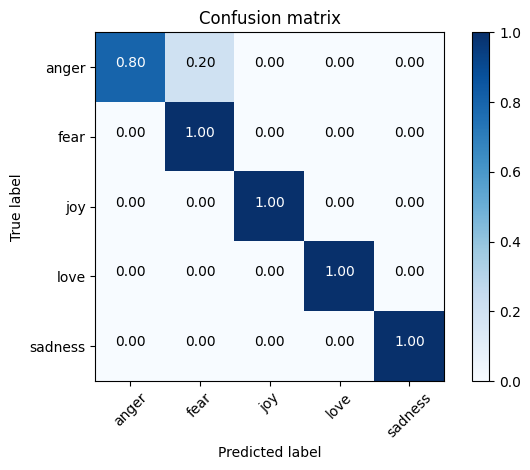

In [ ]:
cm = confusion_matrix(df_metrics['Actual_class'].values, df_metrics['Predicted_class'].values)
classes = label2int.keys()
plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix')

# **Save Model and Tokenizer Locally**

In [ ]:
model_save_folder = 'model/'
tokenizer_save_folder = 'tokenizer/'

path_model = '/content/drive/MyDrive/DLBBT01/src/3.code_model_deploy/deeplearning/' + model_save_folder
path_tokenizer = '/content/drive/MyDrive/DLBBT01/src/3.code_model_deploy/deeplearning/' + tokenizer_save_folder

##create the dir
os.makedirs(path_model, exist_ok=True)
os.makedirs(path_tokenizer, exist_ok=True)

### Now let's save our model and tokenizer to a directory
model.save_pretrained(path_model)
tokenizer.save_pretrained(path_tokenizer)

model_save_name = 'fineTuneModel.pt'
path = path_model + model_save_name
torch.save(model.state_dict(), path)

# **Save Model and Tokenizer to HuggingFace**

In [ ]:
from huggingface_hub import notebook_login
notebook_login()
#Token: hf_xxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [ ]:
notebook_login()

In [ ]:
model.push_to_hub("RinInori/bert-base-uncased_finetuned_sentiments", use_auth_token=True)

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/RinInori/bert-base-uncased_finetuned_sentiments/commit/d8a4383576c160751aeaac4d29f5090711966154', commit_message='Upload BertForSequenceClassification', commit_description='', oid='d8a4383576c160751aeaac4d29f5090711966154', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
tokenizer.push_to_hub("RinInori/bert-base-uncased_finetuned_sentiments", use_auth_token=True)


CommitInfo(commit_url='https://huggingface.co/RinInori/bert-base-uncased_finetuned_sentiments/commit/2a911ba9d8f0eeb6d083c731496a38da7c87276c', commit_message='Upload tokenizer', commit_description='', oid='2a911ba9d8f0eeb6d083c731496a38da7c87276c', pr_url=None, pr_revision=None, pr_num=None)